## Part 1.MNIST数据集的定义及载入

In [32]:
import math
import os
import torch
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as nf
from torch.utils.tensorboard import SummaryWriter

#device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dir = '../processed_data/train/'
val_dir = '../processed_data/val/'
test_dir = '../processed_data/test/'
# 对数据进行归一化
transform = transforms.Compose([transforms.Normalize((0.1307,), (0.3081,))])

class MNIST_Dataset(Dataset):
    def __init__(self, root_dir,setname,transform = None):
        self.setname = setname
        self.root_dir = root_dir
        self.subfolders = sorted(os.listdir(root_dir))
        self.data = []
        self.labels = []
        self.transform = transform
        if (self.setname=='train') or (self.setname=='val'):
            for label, subfolder in enumerate(self.subfolders):
                folder_path = os.path.join(root_dir, subfolder)
                file_list = sorted(os.listdir(folder_path))

                for file_name in file_list:
                    file_path = os.path.join(folder_path, file_name)
                    data = torch.from_numpy(np.load(file_path))
                    self.data.append(data)
                    self.labels.append(label)
        else: #测试集数据
            file_list = sorted(os.listdir(root_dir))
            for file_name in file_list:
                file_path = os.path.join(root_dir, file_name)
                data = torch.from_numpy(np.load(file_path))
                self.data.append(data)
                # self.labels.append(label) 测试数据无标签

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (self.setname=='train') or (self.setname=='val'):
            data_pair = {
                'data': self.data[idx],
                'label': self.labels[idx]
            }
            if self.transform:
                data_pair['data'] = self.transform(data_pair['data'])
        else:
            data_pair = {
                'data': self.data[idx]
            }
            if self.transform:
                data_pair['data'] = self.transform(data_pair['data'])
        return data_pair

train_dataset = MNIST_Dataset(train_dir,"train", transform = transform)
val_dataset = MNIST_Dataset(val_dir,"val", transform = transform)
test_dataset = MNIST_Dataset(test_dir,"test", transform = transform)
#分别创建两个DataLoader载入训练集与测试集的数据
# 注意batch-size表示每批样本的大小，一次训练迭代一个batch.因此len(data_train_loader)表示mini-batch的数目
#batch_idx表示batch批的数目下标
data_train_loader = DataLoader(train_dataset, batch_size=1024 ,shuffle = True, num_workers=0,drop_last = False)  # 训练集的数据被随机打乱
data_val_loader = DataLoader(val_dataset, batch_size=10 ,shuffle = False, num_workers=0,drop_last = False)  # 训练集的数据被随机打乱
data_test_loader = DataLoader(test_dataset, batch_size=256 ,shuffle = False, num_workers=0,drop_last = False)  # 训练集的数据被随机打乱
num_data_val = len(val_dataset)
num_batch_val = np.ceil(num_data_val / data_val_loader.batch_size)
# print(num_batch_val)
# print(len(train_dataset))
# print(len(val_dataset))

## Part2.构建CNN模型

In [33]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 50, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(50, 100, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1600, 200),
            torch.nn.Linear(200, 20),
            torch.nn.Linear(20, 10),
        )

    def forward(self, x):
        # print(x.shape)
        batch_size = x.size(0)
        x = self.conv1(x)  
        x = self.conv2(x) 
        # print(x.shape)
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        # print(x.shape)
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

model = Net().to(device) # 实例化模型

## Part4. 确定训练时需要的优化器和损失函数

In [34]:
model.train()  # 切换模型到训练状态
learning_rate = 0.01
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay = 5e-4)  # lr学习率，momentum冲量
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.99, last_epoch=-1)
writer = SummaryWriter()

## Part5.开始训练

In [35]:
train_loss = 0.0  # 这整个epoch的loss清零
total = 0
correct = 0
epoch = 10
#log to record loss and acc
log=np.zeros([epoch,3])#train_loss,val_loss,val_accuracy
iter_num = 0
for i in range(epoch):
    # print(i)
    train_loss_list = []
    for batch_idx, traindata in enumerate(data_train_loader):
        iter_num += 1
        optimizer.zero_grad()
        # forward + backward + update
        data, labels = traindata['data'].to(device), traindata['label'].to(device)
        outputs = model.forward(data)
        # print(outputs.shape, labels.shape)
        loss = nf.cross_entropy(outputs, labels)
        writer.add_scalar("Loss/train", loss, iter_num)
        loss.backward()
        optimizer.step()
        # 把运行中的loss累加起来
        train_loss_list += [loss.item()]
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        _, predicted = outputs.max(1)
        total += data.shape[0]
        correct += predicted.eq(labels).sum().item()

        if batch_idx % 5 == 4:  # 不想要每一次都出loss，浪费时间，选择每5次出一个平均损失,和准确率
            print('[epoch: %d, batch_idx: %d]: loss: %.3f , acc: %.2f %%'
                    % (i + 1, batch_idx + 1, loss / 100, 100. * correct / total))
            writer.add_scalar('train accuracy per 10 batches', 100. * correct / total, iter_num)
            loss = 0.0  
            correct = 0  
            total = 0
    scheduler.step()  # 优化并更新学习率
    log[i,0]=np.mean(train_loss_list)
    ## 模型验证
    correct = 0
    total = 0
    model.eval() # 切换模型为测试状态(没加drop_out层，因此这句话可以随便注释掉)
    val_loss = []
    with torch.no_grad():  # 测试集不用算梯度
        for batch_idx, valdata in enumerate(data_val_loader):
            data, labels = valdata['data'].to(device), valdata['label'].to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            loss = nf.cross_entropy(outputs, labels)
            val_loss.append(loss.item())
            total += labels.size(0)  # 张量之间的比较运算
            correct_batch = predicted.eq(labels).sum().item()
            correct += predicted.eq(labels).sum().item()
            acc_batch = correct_batch / labels.size(0)
            # print(labels.size(0))
            print('[batch_index: %d]: Accuracy on val set: %.1f %% ' % (batch_idx, 100 * acc_batch))  # 求测试的准确率，正确数/总数
            predicted_list = predicted.tolist()
            targets_list = labels.tolist()
            writer.add_scalar('val accuracy per batch', 100 * acc_batch, batch_idx)
    acc = correct / total
    print('Average accuracy on val set: %.1f %% ' % (100. * acc))  # 求测试的准确率，正确数/总数
    log[i,1]= np.mean(val_loss)
    log[i,2]= acc

[epoch: 1, batch_idx: 5]: loss: 0.023 , acc: 10.06 %
[epoch: 1, batch_idx: 10]: loss: 0.023 , acc: 11.35 %
[epoch: 1, batch_idx: 15]: loss: 0.022 , acc: 18.95 %
[epoch: 1, batch_idx: 20]: loss: 0.021 , acc: 50.96 %
[epoch: 1, batch_idx: 25]: loss: 0.019 , acc: 72.77 %
[epoch: 1, batch_idx: 30]: loss: 0.016 , acc: 80.76 %
[epoch: 1, batch_idx: 35]: loss: 0.010 , acc: 80.51 %
[epoch: 1, batch_idx: 40]: loss: 0.010 , acc: 80.76 %
[epoch: 1, batch_idx: 45]: loss: 0.007 , acc: 89.41 %
[epoch: 1, batch_idx: 50]: loss: 0.008 , acc: 89.96 %
[epoch: 1, batch_idx: 55]: loss: 0.007 , acc: 89.36 %
[batch_index: 0]: Accuracy on val set: 20.0 % 
[batch_index: 1]: Accuracy on val set: 20.0 % 
[batch_index: 2]: Accuracy on val set: 0.0 % 
[batch_index: 3]: Accuracy on val set: 10.0 % 
[batch_index: 4]: Accuracy on val set: 20.0 % 
[batch_index: 5]: Accuracy on val set: 10.0 % 
[batch_index: 6]: Accuracy on val set: 0.0 % 
[batch_index: 7]: Accuracy on val set: 10.0 % 
[batch_index: 8]: Accuracy on val

## Part6.绘制训练与验证时的准确率函数

[[1.51313708 3.95562422 0.13      ]
 [0.58388698 3.62831206 0.13      ]
 [0.53949359 3.34779613 0.14      ]
 [0.50695621 3.24007614 0.15      ]
 [0.47907672 3.05444627 0.16      ]
 [0.46116641 2.88845642 0.15      ]
 [0.447077   2.82900959 0.16      ]
 [0.43280333 2.76740047 0.16      ]
 [0.4225185  2.6490936  0.14      ]
 [0.41397391 2.57485207 0.15      ]]


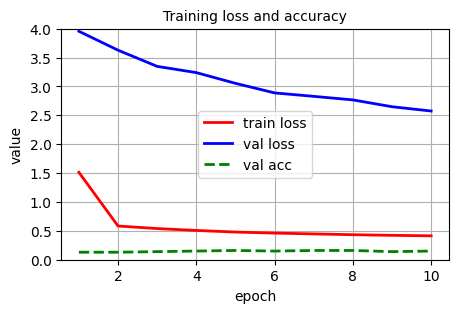

In [36]:
#plot the curve of loss and acc
print(log)
x=np.arange(epoch)
x=x+1
plt.figure(figsize=(5,3))
plt.plot(x,log[:,0],linestyle='-',color='r',label='train loss',linewidth=2)
plt.plot(x,log[:,1],linestyle='-',color='b',label='val loss',linewidth=2)
plt.plot(x,log[:,2],linestyle='--',color='g',label='val acc',linewidth=2)
plt.title('Training loss and accuracy',fontsize=10)
plt.xlabel('epoch',fontsize=10)
plt.ylabel('value',fontsize=10)
plt.legend(fontsize=10)
plt.ylim(0,4)
plt.grid()
plt.savefig('../Results/training_loss_record.png')
plt.show()

## Part7.保存模型的状态字典

In [37]:
# 等两次完整的迭代进行完毕后，保存训练好的模型及其参数
save_info = {  # 保存的信息: 1.迭代步数 2.优化器的状态字典 3.模型的状态字典
    "iter_num": iter_num, "optimizer": optimizer.state_dict(), "model": model.state_dict()
}
save_path = "../Results/model.pth"  # 将模型存储的位置在当前根目录的文件夹中
torch.save(save_info, save_path)

## Part8.模型测试

In [38]:
import math
# print(data_test_loader.batch_size)
predicted_list = []
model.eval() # 切换模型为测试状态(没加drop_out层，因此这句话可以随便注释掉)
with torch.no_grad():  # 测试集不用算梯度
    for batch_idx, testdata in enumerate(data_test_loader):
        data = testdata['data'].to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.to('cpu').data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
        # print(predicted.shape)
        predicted = predicted.tolist()
        if batch_idx <= math.floor(len(test_dataset)/data_test_loader.batch_size) -1:
            for i in range(data.size(0)):
                predicted_list.append(predicted[i])
        else:
            for i in range(len(test_dataset) - batch_idx * data_test_loader.batch_size):
                predicted_list.append(predicted[i])

## Part9.将模型测试结果存入.txt和.csv中

In [ ]:
# 将预测结果写入Predict.txt文件中
count = 0
with open('../Results/Predict.txt', 'w') as file:
    # 遍历列表中的元素并将其写入文件
    for item in predicted_list:
        file.write(str(count) + '.npy'+ ' ')
        file.write(str(item) + '\n')
        count = count + 1
# 将预测结果写入Predict.csv文件中
with open('../Results/Predict.csv', 'w') as file:
    file.write("predicted class label" + '\n')
    # 遍历列表中的元素并将其写入文件
    for item in predicted_list:
        file.write(str(item) + '\n')